# HW 1: Alexander Marinskiy

## Task

Download data https://cloud.mail.ru/public/4YBW/XvCMVyxc6

You should build full ML pipeline and get best AUC.

Important stages in pipeline:

 1. Feature selection
 -  Cross validation
 -  Hyper parameters tuning
 -  Compare minimum 2 models

In [46]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## 1. Loading data

In [3]:
# load data
df = pd.read_csv('dataset_simple.csv')
df.head(n=3)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,label
0,-0.272674,0.801643,-0.650531,0.952486,-0.153037,0.427145,-1.085534,1.318513,0.002588,-1.849832,...,-0.572848,-0.448690,0.073369,-0.845503,-1.074903,0.222103,-1.024658,-0.711647,0.036411,1
1,0.201004,-0.263537,-0.793137,-4.483672,0.745123,1.156577,0.351558,1.735511,-1.490988,-0.327063,...,1.045496,1.494638,-0.776573,-1.219524,-0.756398,-0.963046,0.488610,0.313609,-0.490794,0
2,-1.834495,-0.305209,0.053789,4.448289,1.294481,1.241900,-1.358354,-0.211469,-0.186544,0.964812,...,0.917945,0.920003,0.690022,-0.834381,-0.261806,-0.061880,-1.177730,-1.345305,-0.085971,0


In [4]:
# check the shape of data
df.shape

(9999, 1001)

In [5]:
# check if sample is balanced
df['label'].value_counts()

0    5068
1    4931
Name: label, dtype: int64

We can see that training sample is balanced

## 2. Creating samples

### Initial test train split

In [6]:
# create initial train and holdout sample
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis = 1), df['label'], 
                                                    test_size=0.25, random_state=42, shuffle=True)

### Scaled samples

In [7]:
# scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# re-assign names of rows and columns 
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

X_train_scaled.columns = X_train.columns.values
X_train_scaled.index = X_train.index

X_test_scaled.columns = X_test.columns.values
X_test_scaled.index = X_test.index

X_train_scaled.head(5)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999
4900,-1.024903,-0.773129,1.164818,0.385687,-1.450712,1.559885,1.587827,0.879211,-3.197993,-0.290895,...,1.774808,-0.066877,-1.534803,0.151638,-1.093780,1.038295,0.665654,0.615080,-1.379045,0.990205
4375,-0.050794,0.999154,-0.577595,-0.190203,-0.049139,-0.960277,0.975478,0.009504,0.502809,0.622172,...,-1.020989,-2.296338,-0.498952,0.408081,-2.722449,1.224749,-0.737418,-0.925168,-0.647342,0.167656
7296,0.259159,0.574684,1.454707,0.563196,1.017043,0.406381,-0.365921,-0.642002,1.053974,-1.115893,...,0.944405,1.414255,0.578379,-0.231741,-1.235242,0.398272,0.912794,1.231427,-0.913918,-0.542188
9804,0.182755,2.993037,0.297163,0.127897,1.111414,-0.093488,-1.479651,1.703470,3.006690,-0.734237,...,1.370249,-0.964772,-0.452219,0.654951,0.593571,1.478053,-0.442785,0.777257,-0.370619,-0.042624
1101,0.165573,0.471304,0.736538,-0.278460,-0.593384,-0.235622,-0.656466,-0.749498,0.337183,-0.649691,...,0.051939,0.119996,-0.524305,0.556665,0.161472,-1.091755,-2.030970,0.278783,0.490360,0.487078


### Feature selection

In [8]:
# We use the random forest as a base classifier for feature selection.
base_clf = RandomForestClassifier(n_estimators=100)

# Set a minimum threshold of 2*mean
sfm = SelectFromModel(base_clf, threshold="2*mean")
sfm.fit(X_train_scaled, y_train)
n_features = sfm.transform(X_train_scaled).shape[1]

In [9]:
print('Features selected:', n_features)

Features selected: 61


In [10]:
# Prepere test and train samples with only main features
X_train_scaled_main = sfm.transform(X_train_scaled)
X_test_scaled_main = sfm.transform(X_test_scaled)

## 3. Model selection

In [48]:
# build function for model tuning
def model_tuning(model_name, model, param, X_train, y_train, X_test, y_test):
    clf = GridSearchCV(model, param, scoring='roc_auc', n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)
    print(clf.best_estimator_)
    y_pred_proba = [x[1] for x in clf.best_estimator_.predict_proba(X_test)]
    print()
    print('ROC-AUC of', model_name, 'model on cross-validation:', clf.best_score_)
    print('ROC-AUC of', model_name, 'model on holdout:', roc_auc_score(y_test, y_pred_proba))
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    # making the graph
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### KNN

In [58]:
param_knn = {
 'n_neighbors':range(1,10,10),
 'p': [1, 2]
}

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

ROC-AUC of KNN model on cross-validation: 0.9789193667375155
ROC-AUC of KNN model on holdout: 0.9823717547565454


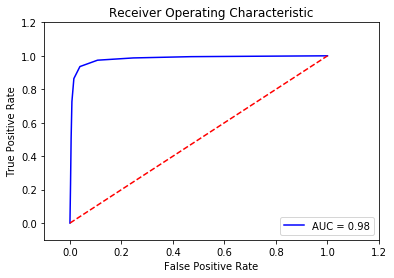

In [59]:
model_tuning('KNN', KNeighborsClassifier(), param_knn, X_train_scaled_main, y_train, X_test_scaled_main, y_test)

### Logistic regression

In [54]:
param_logreg = {
 'penalty': ['l1', 'l2'],
 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

C:\Users\Alex\Anaconda2\envs\Py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

ROC-AUC of Logistic regression model on cross-validation: 0.8981065512430376
ROC-AUC of Logistic regression model on holdout: 0.9102349084826744


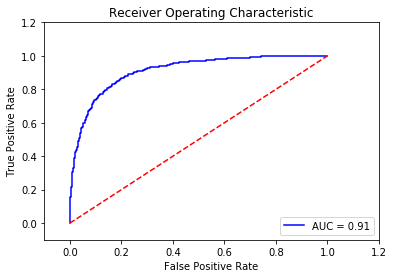

In [55]:
model_tuning('Logistic regression', LogisticRegression(), param_logreg, 
             X_train_scaled_main, y_train, X_test_scaled_main, y_test)

### Random forest

In [56]:
param_rf = {
 'max_depth': [25, 50, 100, None],
 'min_samples_leaf': [1, 5],
 'n_estimators': [200, 400, 600]}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ROC-AUC of Random forest model on cross-validation: 0.9526624874339507
ROC-AUC of Random forest model on holdout: 0.9631289509509238


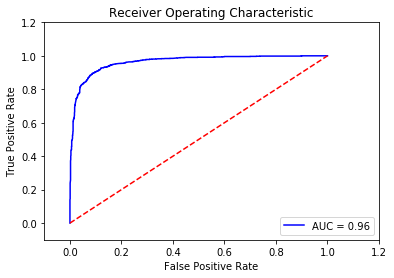

In [57]:
model_tuning('Random forest', RandomForestClassifier(), param_rf, 
             X_train_scaled_main, y_train, X_test_scaled_main, y_test)

## 4. Results

 * The best results on holdout data showed KNN model on selected features with parameters n_neighbors = 9, p = 2 
 * Best ROC-AUC score is 0.98